# Data Analysis for Amazon All Beauty reviews datasets
###### Piotr Stachowicz, Jakub Malczak

### Config

In [1]:
FILE = "Amazon_All_Beauty"
CLEAN = True

### 1. Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.json as pjs
import json
import seaborn as sns

In [3]:
def clean(inp_path: str, out_path: str, columns: list[str]) -> None:
    with open(inp_path, 'r') as f, open(out_path, 'w+') as w:
        for row in f:
            entry = json.loads(row)

            new_entry = dict()

            for col in columns:
                try:
                    new_entry[col] = entry[col]
                except Exception:
                    print(f'There was an error while creating new entry! Probably {col} does not exist in input file!')

            w.write(json.dumps(new_entry) + '\n')

def convert_metadata(inp_path: str, out_path: str):
    with open(inp_path, 'r') as f, open(out_path, 'w+') as w:
            for line in f:
                data = json.loads(line)
                asin = data['parent_asin']
                categories = data.get('categories', [])

                if not categories:
                    continue

                category = categories[-1][-1] if isinstance(categories[-1], list) else categories[-1]
                
                new_entry = {
                    'parent_asin': asin,
                    'category': category
                }

                w.write(json.dumps(new_entry) + '\n')

### 2. Dataset loading

In [4]:
if CLEAN:
    dataset = f"./{FILE}.jsonl"
    meta = f"./meta_{FILE}.jsonl"

    clean(
        dataset, 
        f"./{FILE}_cleaned.jsonl", 
        ['rating', 'asin', 'parent_asin', 'user_id', 'timestamp', 'verified_purchase']
    )
    convert_metadata(meta, f"./meta_{FILE}_cleaned.jsonl")

dataset = f"./{FILE}_cleaned.jsonl"
meta = f"./meta_{FILE}_cleaned.jsonl"

try:
    df: pd.DataFrame = pjs.read_json(dataset, parse_options=pjs.ParseOptions()).to_pandas()
except Exception:
    raise Exception(f"Error while loading file: {dataset}")

### 3. Fun statistics

#### 3.1 Data structure

In [5]:
df.head()

,rating,asin,parent_asin,user_id,timestamp,verified_purchase
0,5.0,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,True
1,4.0,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,True
2,5.0,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,True
3,1.0,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,True
4,5.0,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,True


In [6]:
df.keys()

Index(['rating', 'asin', 'parent_asin', 'user_id', 'timestamp',
       'verified_purchase'],
      dtype='object')

#### 3.2 Unique Users & Products

In [7]:
unique_users = df['user_id'].nunique()
unique_products = df['asin'].nunique()

print(f"Number of unique users: {unique_users}")
print(f"Number of unique products: {unique_products}")

Number of unique users: 631986
Number of unique products: 115709


#### 3.3 Average Rating

In [8]:
ratings = df.shape[0]
avg_rating = df['rating'].sum() / ratings

print(f"Average rating is: {avg_rating}")

Average rating is: 3.9602453501499584


In [9]:
print(ratings)

701528


#### 3.4 Average Reviews per User

In [10]:
avg_user_reviews = ratings / unique_users

print(f"Average reviews per user: {avg_user_reviews}")

Average reviews per user: 1.1100372476605493


#### 3.5 Average Reviews per Product

In [11]:
avg_product_reviews = ratings / unique_products

print(f"Average reviews per product: {avg_product_reviews}")

Average reviews per product: 6.0628645999879005


#### 3.6 Number of reviews per user

In [12]:
user_counts = df.groupby("user_id").size().reset_index(name="review_count")

##### 3.6.1 Top 10 reviewers

In [13]:
user_counts.sort_values('review_count', ascending=False).head(10)

,user_id,review_count
340457,AG73BVBKUOH22USSFJA5ZWL7AKXA,165
156408,AEZP6Z2C5AVQDZAJECQYZWQRNG3Q,146
92332,AEMP3A7IKW37CMWFXNKXWW6HGJHA_1,115
522437,AHDVSLWHSORYGG3S5QZMVDFNOXUQ,108
472775,AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1,87
206979,AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_2,83
302694,AFXF3EGQTQDXMRLDWFU7UBFQZB7Q,81
78240,AEJU3Z6HDAERETMYI2CXBQVPPDFA,79
622381,AHY2TURQPNIDXZGH2CMQLZ343YMQ,69
101652,AEOK4TQIKGO23SJKZ6PW4FETNNDA_1,68


##### 3.6.2 Distribution plot

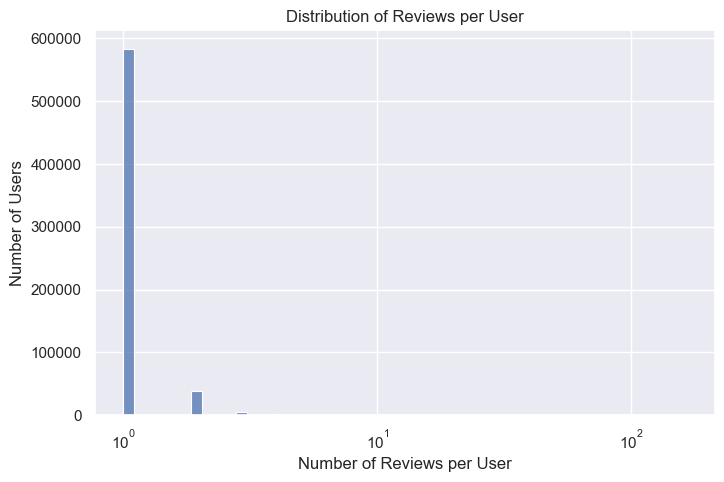

In [14]:
plt.figure(num=0, figsize=(8, 5))
sns.set_theme(style="darkgrid")

sns.histplot(
    user_counts['review_count'], 
    bins=50, log_scale=True
)

plt.xlabel("Number of Reviews per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Reviews per User")

plt.show()

#### 3.7 User x Product Matrix Sparsity

In [15]:
matrix_size = unique_users * unique_products
matrix_sparsity = 1.0 - (ratings / matrix_size)

print(f"Matrix sparsity of dataset: {matrix_sparsity}%")

Matrix sparsity of dataset: 0.9999904066472992%


#### 3.8 Number of reviews per product

In [16]:
product_counts = df.groupby(["asin"]).size().reset_index(name="review_count")

##### 3.8.1 Top 10 reviewed products

In [17]:
product_counts.sort_values(by="review_count", ascending=False).head(10)

,asin,review_count
5476,B007IAE5WY,1962
8717,B00EEN2HCS,1750
49919,B07C533XCW,1513
15524,B00R1TAN7I,1372
93618,B08L5KN7X4,1343
23259,B019GBG0IE,1328
38782,B0719KWG8H,1168
6364,B0092MCQZ4,1128
19090,B0107QYW14,1112
5290,B0070Z7KME,934


##### 3.8.2 Distribution plot

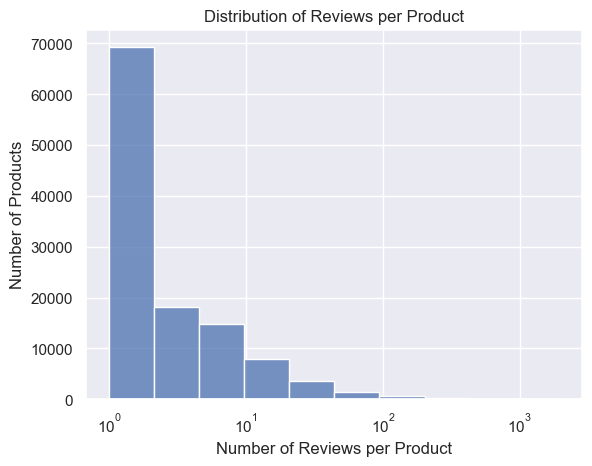

In [18]:
plt.figure(num=1)
sns.set_theme(style="darkgrid")

sns.histplot(
    data=product_counts['review_count'], 
    bins=10,
    log_scale=True
)

plt.xlabel("Number of Reviews per Product")
plt.ylabel("Number of Products")
plt.title("Distribution of Reviews per Product")

plt.show()

#### 3.9 Product lifespan analysis

In [19]:
lifespan_df = df.groupby(by='asin')['timestamp'].agg(['min', 'max'])
lifespan_df['max'] = pd.to_datetime(lifespan_df['max'], unit='ms')
lifespan_df['min'] = pd.to_datetime(lifespan_df['min'], unit='ms')

lifespan_df['lifespan'] = lifespan_df['max'] - lifespan_df['min']
lifespan_df['lifespan'] = lifespan_df['lifespan'].dt.days

In [20]:
lifespan_df = lifespan_df[lifespan_df['lifespan'] != 0]

lifespan_df.head()

,min,max,lifespan
asin,,,
0124784577,2019-06-24 23:29:59.244,2019-09-09 14:59:29.877,76
069267599X,2016-10-21 16:55:20.000,2022-01-24 15:42:09.966,1920
0764490117,2013-06-21 21:07:30.000,2015-09-01 19:48:49.000,801
0816091846,2014-08-16 02:14:18.000,2017-08-19 00:26:40.210,1098
0966068432,2016-11-18 15:07:40.000,2017-06-19 17:50:14.836,213


##### 3.9.1 Product lifespan distribution

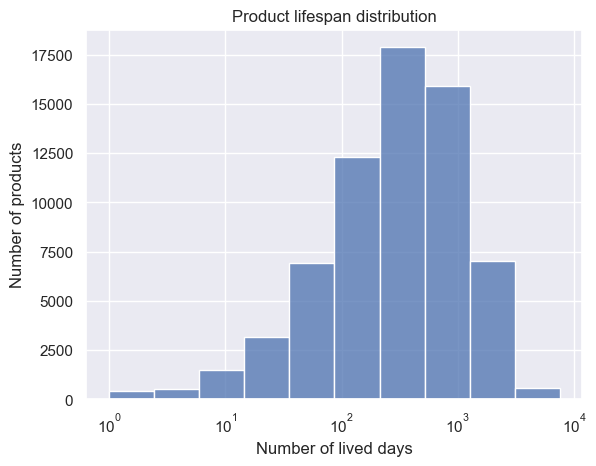

In [21]:
plt.figure(num=3)
sns.histplot(
    lifespan_df['lifespan'],
    log_scale=True,
    bins=10
)
plt.xlabel("Number of lived days")
plt.ylabel("Number of products")
plt.title("Product lifespan distribution")
plt.show()

##### 3.9.2 Seasonality of products

In [22]:
seasonality_df = df.copy()
seasonality_df['timestamp'] = pd.to_datetime(seasonality_df['timestamp'], unit='ms')

In [23]:
seasonality_df = seasonality_df[seasonality_df['verified_purchase'] == True]

In [24]:
seasonality_df.head()

,rating,asin,parent_asin,user_id,timestamp,verified_purchase
0,5.0,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,True
1,4.0,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,True
2,5.0,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,True
3,1.0,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,True
4,5.0,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,True


In [25]:
seasonality_df.set_index('timestamp', inplace=True)

In [26]:
monthly_transaction_count = seasonality_df['verified_purchase'].resample('MS').count().reset_index(name="purchase_count")
monthly_transaction_count.head(10)

,timestamp,purchase_count
0,2002-10-01,1
1,2002-11-01,1
2,2002-12-01,2
3,2003-01-01,2
4,2003-02-01,1
5,2003-03-01,2
6,2003-04-01,2
7,2003-05-01,1
8,2003-06-01,2
9,2003-07-01,0


##### 3.9.3 Top 20 highest selling months

In [27]:
monthly_transaction_count.sort_values(by='purchase_count', ascending=False).head(20)

,timestamp,purchase_count
221,2021-03-01,13111
222,2021-04-01,11919
219,2021-01-01,11873
207,2020-01-01,11371
213,2020-07-01,11104
214,2020-08-01,11032
206,2019-12-01,10976
220,2021-02-01,10966
216,2020-10-01,10792
218,2020-12-01,10501


##### 3.9.4 Time series

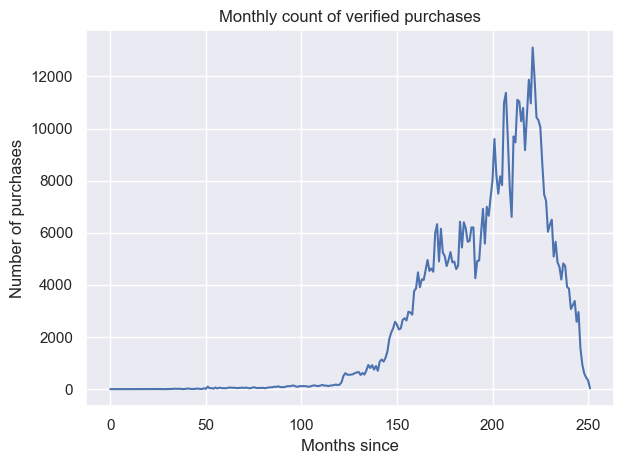

In [28]:
plt.figure(num=4)
monthly_transaction_count['purchase_count'].plot(title="Monthly count of verified purchases")
plt.xlabel('Months since')
plt.ylabel('Number of purchases')
plt.tight_layout()
plt.grid(True)
plt.show()

In [29]:
month_subseries_count = monthly_transaction_count.copy()
month_subseries_count['month'] = month_subseries_count['timestamp'].dt.month

foo = month_subseries_count.groupby(by='month')['purchase_count'].sum().reset_index(name='purchase_count')
foo.head(12)

,month,purchase_count
0,1,60905
1,2,52272
2,3,58075
3,4,51140
4,5,52324
5,6,51360
6,7,56703
7,8,54574
8,9,47747
9,10,49895


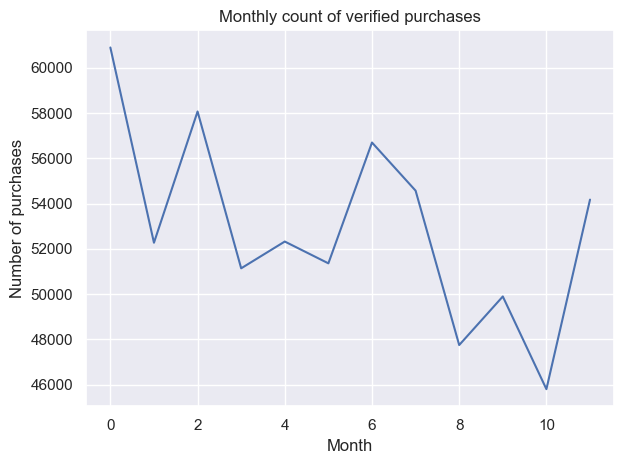

In [30]:
plt.figure(num=5)
foo['purchase_count'].plot(title="Monthly count of verified purchases")
plt.xlabel('Month')
plt.ylabel('Number of purchases')
plt.tight_layout()
plt.grid(True)
plt.show()

#### 3.10 Rating distribution

In [31]:
rating_counts = df['rating'].value_counts().sort_index()
rating_counts.head()

rating
1.0    102080
2.0     43034
3.0     56307
4.0     79381
5.0    420726
Name: count, dtype: int64

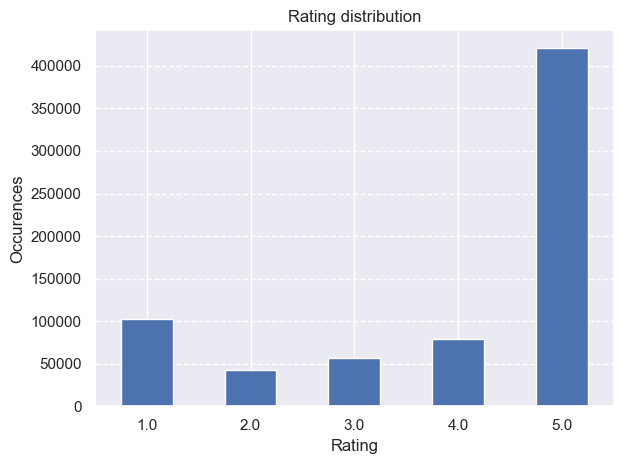

In [32]:
plt.figure(num=6)
rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Occurences')
plt.title('Rating distribution')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

#### 3.11 Subclasses

In [ ]:
try:
    df2: pd.DataFrame = pjs.read_json(meta, parse_options=pjs.ParseOptions()).to_pandas()
except Exception:
    raise Exception(f"Error while loading file: {meta}")

In [ ]:
df2.head()

In [ ]:
df2 = pd.merge(df, df2, on='parent_asin', how='left')

In [ ]:
df2.head()

In [ ]:
subcategories_df = df2.dropna(subset=['category'])
unique_parent_asins_in_subcategory = subcategories_df[['parent_asin', 'category']].drop_duplicates()
product_count_by_subcategory = unique_parent_asins_in_subcategory.groupby('category')['parent_asin'].count().sort_values(ascending=False)

In [ ]:
product_count_by_subcategory.head()

In [ ]:
top_n_subcategories = product_count_by_subcategory.head(20)
others_count = product_count_by_subcategory.iloc[20:].sum()

if others_count > 0:
    top_n_subcategories['Other'] = others_count

In [ ]:
barplot = sns.barplot(x=top_n_subcategories.values, y=top_n_subcategories.index, palette="viridis", hue=top_n_subcategories.index, dodge=False, legend=False)
plt.xlabel('Product occurences')
plt.ylabel('Subcategory')
plt.title(f'Product count in subcategories')
plt.gca().invert_yaxis()

### 4.0 Check photo availability

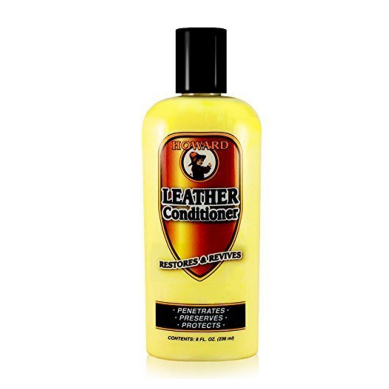

In [35]:
import requests
from PIL import Image
from io import BytesIO

with open(f'./meta_{FILE}.jsonl', 'r') as f:
    data = f.readline()
    first = json.loads(data)

    image_url = first['images'][0]['large']

    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
